<a id="contents"></a>

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Изучение-общей-информации" data-toc-modified-id="Изучение-общей-информации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение общей информации</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Приоритизация-гипотез" data-toc-modified-id="Приоритизация-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Приоритизация гипотез</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-A/B-теста" data-toc-modified-id="Анализ-A/B-теста-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ A/B-теста</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

# Приоритизация гипотез и анализ A/B-теста для интернет-магазина

## Описание проекта

В данном проекте мы приоритизируем гипотезы с целью увеличения выручки интернет-магазина, и анализируем результаты A/B-теста для принятия окончательного решения по гипотезе.

Данные представлены в трех файлах:

1) данные по гипотезам **hypothesis.csv** с полями:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

2) данные о заказах **orders.csv** с полями:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

3) данные о посещениях сайта интернет-магазина **visitors.csv** с полями:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

<a href="#contents">к оглавлению</a>

## Изучение общей информации

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from scipy import stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# задаем количество символов в столбце при просмотре таблицы
pd.set_option('display.max_colwidth', 150)

In [3]:
# загружаем файлы
datasets = ['hypothesis', 'orders', 'visitors']
dfs = {}
for dataset in datasets:
    try:
        dfs[dataset] = pd.read_csv('/datasets/' + dataset + '.csv') # путь яндекса
    except:
        dfs[dataset] = pd.read_csv(dataset + '.csv') # мой путь

In [4]:
# Выведем информацию по датасетам
for key, value in dfs.items():
    print(' ' + '-' * len(key))
    print('|' + key + '|')
    print(' ' + '-' * len(key))
    print(value.info())
    print()

 ----------
|hypothesis|
 ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

 ------
|orders|
 ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

 --------
|visitors|
 --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+

Пропусков в данных нет. Типы данных в столбцах с датой неверно указаны. Названия столбцов в таблицах с гипотезами и заказами нужно привести в надлежащий вид.

In [5]:
# сохраним первый датасет с гипотезами в таблицу hypothesis
hypothesis = dfs['hypothesis']

In [6]:
# приведем названия столбцов в нижний регистр в таблице с гипотезами
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [7]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


У нас имеется 9 гипотез для увеличения выручки.

In [8]:
# сохраним второй датасет с заказами в таблицу orders
orders = dfs['orders']

In [9]:
# приведем названия столбцов в нижний регистр и добавим нижнее подчеркивание в таблице с заказами
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [10]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
# сохраним третий датасет с посетителями в таблицу visitors
visitors = dfs['visitors']

In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# напишем функцию для проверки стартовой и последней даты в данных
def check_period(df, col):
    display('Первая дата: '+ df[col].min())
    display('Последняя дата: '+ df[col].max())

In [14]:
# проверим стартовую и последнюю дату в заказах
check_period(orders, 'date')

'Первая дата: 2019-08-01'

'Последняя дата: 2019-08-31'

In [15]:
# проверим стартовую и последнюю дату в таблице с пользователями
check_period(visitors, 'date')

'Первая дата: 2019-08-01'

'Последняя дата: 2019-08-31'

Период данных - 1-31 августа 2019 года.

In [16]:
# посчитаем уникальных покупателей
orders['visitor_id'].nunique()

1031

В заказах 1031 уникальных покупателей.

In [17]:
len(orders)

1197

А вот покупок совершено 1197.

In [18]:
# посмотрим на количество пользователей в каждой группе
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

В группе B больше пользователей.

In [19]:
# посмотрим на количество пользователей в каждой группе
orders.groupby('group')['visitor_id'].count()

group
A    557
B    640
Name: visitor_id, dtype: int64

In [20]:
# посмотрим на количество пользователей в каждой группе
orders.groupby('group')['visitor_id'].nunique()

group
A    503
B    586
Name: visitor_id, dtype: int64

В группе B больше покупок и больше уникальных покупателей.

### Вывод
Данные соответствуют описанию. Названия столбцов были приведены в надлежащий вид. В данных нет пропусков. Нужно поменять типы данных в столбцах с датой, а также и проверить на дубликаты. 

<a href="#contents">к оглавлению</a>

## Предобработка данных

In [21]:
# приведем дату заказа к формату дата и время
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [22]:
# приведем дату визита к формату дата и время
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [23]:
# проверим заказы на дубликаты
orders.duplicated().sum()

0

In [24]:
# проверим визиты на дубликаты
visitors.duplicated().sum()

0

In [25]:
# сохраним таблицы с заказами и визитами в список
tables = [orders, visitors]

In [26]:
# проверим типы столбцов с датой и временем после изменения типа
for table in tables:
    print(table.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None



Типы данных изменены.

### Вывод
Типы данных в столбцах с датой были приведены к формату дата. Дубликатов в данных нет. Можно приступить к дальнейшему анализу данных.

<a href="#contents">к оглавлению</a>

## Приоритизация гипотез

Применим фреймворк ICE (impact, confidence, efforts) для приоритизации гипотез. Этот фреймворк учитывает показатели воздействия, уверенности и усилий. Чем выше рейтинг, тем приоритетнее гипотеза.

In [27]:
# создадим столбец ICE с рейтингом гипотезы
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [28]:
# отсортируем гипотезы по убыванию приоритета
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы - под индексами 8, 0 и 7.

Применим фреймворк RICE (reach, impact, confidence, efforts) для приоритизации гипотез. Данный фреймворк похож на ICE, но еще учитывает показатель охвата reach.

In [29]:
# создадим столбец RICE с рейтингом гипотезы
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [30]:
# отсортируем гипотезы по убыванию приоритета
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


На этот раз лидирует гипотеза под индексом 7, затем следует гипотеза 2, 0 и 6.

Ниже построим диаграмму рассеяния гипотез по баллам ICE-RICE.

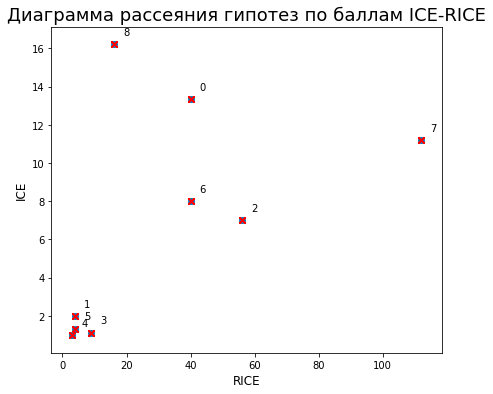

In [31]:
# диаграмма рассеяния, RICE по оси x, ICE по оси y, точки обозначают каждую гипотезу
x = hypothesis['RICE'].values
y = hypothesis['ICE'].values
types = hypothesis.reset_index()['index'].values

fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x, y)

ax.set_xlabel('RICE', fontsize=12)
ax.set_ylabel('ICE', fontsize=12)
ax.set_title('Диаграмма рассеяния гипотез по баллам ICE-RICE', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(9,9), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

Видим, что гипотеза 7 лидирует по обоим показателям.

### Вывод
При применении фреймворка ICE лидируют гипотезы 8, 0 и 7. При применении фреймворка RICE лидируют гипотезы 7, 2, 0 и 6. При применении фреймворка ICE, в лидеры выбилась гипотеза 7. Это произошло, потому что у гипотезы 7 показатель reach равен 10, тогда как у гипотезы 8 он равен всего 1. У гипотез 2 и 6 показатель reach составляет 8 и 5 соответственно, поэтому они также лидируют при применении RICE. Гипотеза 0 находится в числе лидеров по результатам применения обоих фреймворков, за счет высокого показателя impact в 10 баллов.

Гипотеза "Добавить форму подписки на все основные страницы" имеет больший балл по показателю охвата reach по сравнению с гипотезой "Запустить акцию, дающую скидку на товар в день рождения".

<a href="#contents">к оглавлению</a>

## Анализ A/B-теста
У нас имеются результаты A/B-теста, а именно данные по заказам и посетителям интернет-магазина. Проанализируем результаты и сделаем выводы и предположения касательно гипотезы. Сначала создадим объединенную таблицу с кумулятивными данными из таблиц с зказами и посещениями.

In [32]:
# создадим датафрейм с уникальными парами значений 'date' и 'group' из таблицы orders
dates_groups = orders[['date', 'group']].drop_duplicates()

In [33]:
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Создадим таблицу с кумулятивными показателями orders_aggregated, содержащую:
- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

In [34]:
# таблица с кумулятивными показателями orders_aggregated
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(orders["date"] <= x["date"], orders["group"] == x["group"])
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transaction_id": "nunique",
            "visitor_id": "nunique",
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(by=["date", "group"])

In [35]:
orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Создадим таблицу с кумулятивными показателями visitors_aggregated, содержащую:
- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [36]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(visitors["date"] <= x["date"], visitors["group"] == x["group"])
    ].agg({"date": "max", "group": "max", "visitors": "sum"}),
    axis=1,
).sort_values(by=["date", "group"])

In [37]:
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [38]:
# создадим таблицу cumulative_data, объединив orders_aggregated и visitors_aggregated 
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [39]:
# переименуем столбцы
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [40]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Объявим переменные cumulative_revenue_A и cumulative_revenue_B, в которых сохраним данные о датах, выручке и числе заказов в группах A и B из общей кумулятивной таблицы. Построим график кумулятивной выручки по группам.

In [41]:
# выручка и заказы по группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [42]:
cumulative_revenue_A.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [43]:
# выручка и заказы по группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

In [44]:
cumulative_revenue_B.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


Теперь построим график кумулятивной выручки по группам.

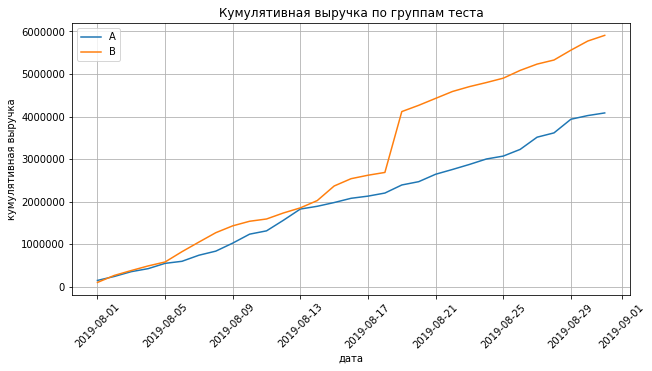

In [45]:
# Строим график кумулятивной выручки по группам А и B
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.title('Кумулятивная выручка по группам теста')
plt.xlabel('дата')
plt.ylabel('кумулятивная выручка')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Сегмент B лидирует по кумулятивной выручке почти с самого начала. Где-то в середине теста происходит резкий скачек кривой сегмента B, и он продолжал лидировать весь остаток теста. Похоже, что аномально большие заказы повлияли на такой резкий рост.

Построим график кумулятивного среднего чека по группам.

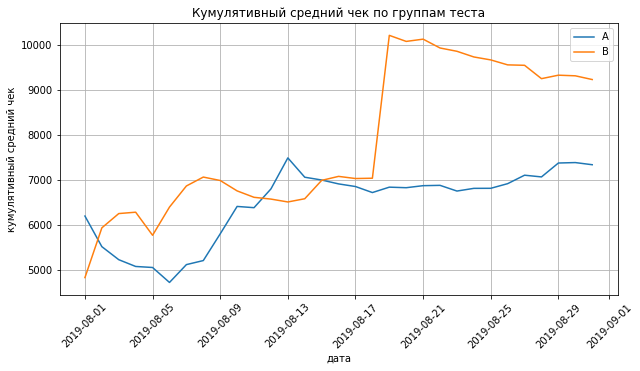

In [46]:
# Строим график кумулятивного среднего чека по группам А и B
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.title('Кумулятивный средний чек по группам теста')
plt.xlabel('дата')
plt.ylabel('кумулятивный средний чек')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Кумулятивное значение среднего чека по группам колеблется в начале теста. Сегменты лидировали с переменным успехом. В середине теста группа B делает резкий скачок вверх. Сегмент B закрепился в позиции лидера начиная с середины теста. Скорее всего есть выбросы, от которых нужно будет избавится.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Также добавим линию нулевого относительного изменения.

In [47]:
# объединим таблицы по группам и сохраните в переменной merged_сumulative_revenue
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date',\
                            right_on='date', how='left', suffixes=['A', 'B'])

In [48]:
merged_cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


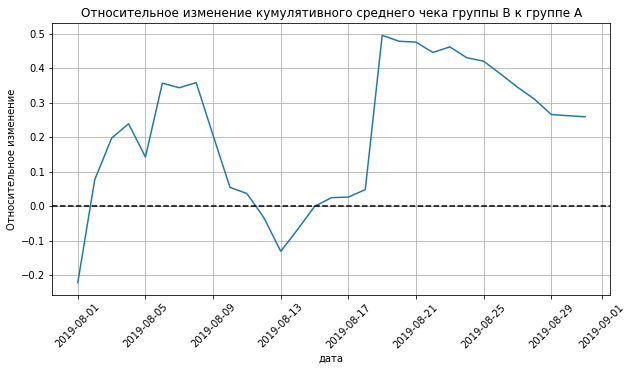

In [49]:
# график относительного изменения кумулятивного среднего чека группы B к группе A  с пунктирной линией ноль
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']\
/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Результаты значительно и резко менялись в течение теста. Вероятно, были аномально большие заказы. Большую часть теста лидировала группа B. Результаты группы B начали ухудшатья снова с середины теста.

Построим график кумулятивной конверсии по группам. 

In [50]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [51]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [52]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

In [53]:
cumulative_data_A.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


In [54]:
# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

In [55]:
cumulative_data_B.head()

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793


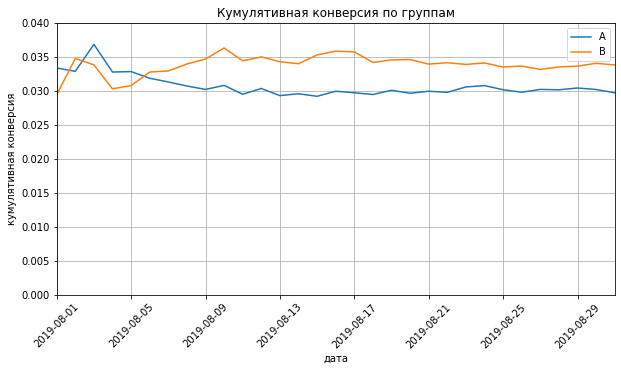

In [56]:
# строим график кумулятивной конверсии по группам
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('дата')
plt.ylabel('кумулятивная конверсия')
plt.xticks(rotation=45)
plt.legend()
# задаем масштаб осей
plt.axis(['2019-08-01', '2019-08-31', 0, 0.04])
plt.show()

В начале теста группа A имела большую конверсию. Но постепенно группа B зафиксировалась около одного значения, больше значения группы A.

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

In [57]:
# объединим конверсии по группам A и B  в одну таблицу
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].\
merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [58]:
merged_cumulative_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


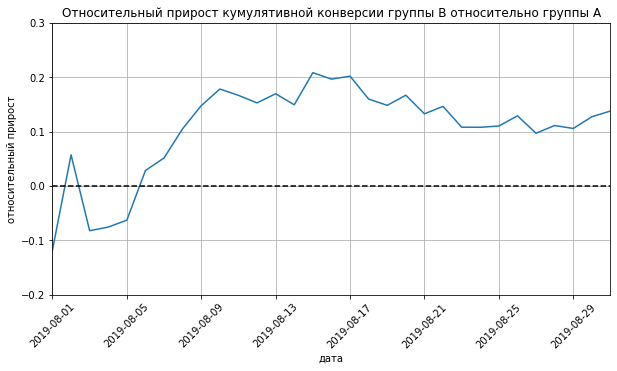

In [59]:
# график относительного прироста кумулятивной конверсии группы B относительно группы A
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']\
 /merged_cumulative_conversions['conversionA']-1)
plt.title('Относительный прирост кумулятивной конверсии группы B относительно группы A')
plt.xlabel('дата')
plt.ylabel('относительный прирост')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
#plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(['2019-08-01', '2019-08-31', -0.2, 0.3])
plt.show()

Почти с самого начала теста группа B лидирует по конверсии, фиксируясь около прироста в 15% относительно группы A.

Построим точечный график количества заказов по пользователям.

In [60]:
# создадим таблицу заказов по пользователям
orders_by_users = (
    orders.drop(['revenue', 'date'], axis=1)
    .groupby(['group', 'visitor_id'], as_index=False)
    .agg({'transaction_id': 'nunique'})
)

In [61]:
orders_by_users.columns = ['group', 'visitor_id', 'orders']

In [62]:
orders_by_users.head()

,group,visitor_id,orders
0,A,8300375,1
1,A,11685486,1
2,A,54447517,1
3,A,66685450,1
4,A,78758296,1


In [63]:
# создадим серию с диапазоном равным количеству строк в таблице заказов по пользователям, от 0 до номера последней строки таблицы
x_values = pd.Series(range(0,len(orders_by_users)))

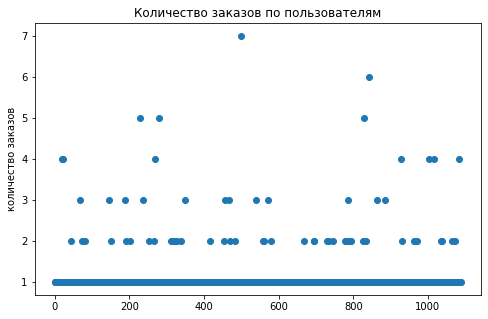

In [64]:
# точечный график заказов по пользователям
plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Количество заказов по пользователям')
plt.ylabel('количество заказов')
plt.show()

Ниже построим точечный график заказов с разбивкой по группе теста.

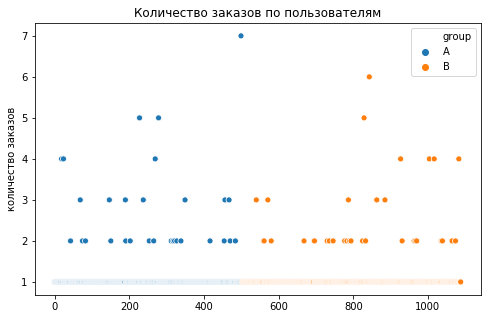

In [65]:
# точечный график заказов на покупателя с разбивкой по группам
plt.figure(figsize=(8, 5))
sns.scatterplot(pd.Series(range(0,len(orders_by_users))), y='orders', hue='group', data=orders_by_users)
plt.title('Количество заказов по пользователям')
plt.ylabel('количество заказов')
plt.show()

Видим, что в группе В больше покупателей с аномально большим количеством заказов.

Много пользователей с 2-3 заказами. Их точная доля не ясна - непонятно, считать их аномалиями или нет.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, чтобы выберать границу для определения аномальных пользователей.

In [66]:
# считаем 95-й и 99-й перцентили
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше чем 2 заказа. 1% пользователей оформляли больше чем 4 заказа. Можно выбрать 2 или 3 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

Построим точечный график стоимостей заказов.

In [67]:
# создадим серию с диапазоном равным количеству строк в таблице заказов, от 0 до номера последней строки таблицы
x_values_2 = pd.Series(range(0,len(orders['revenue'])))

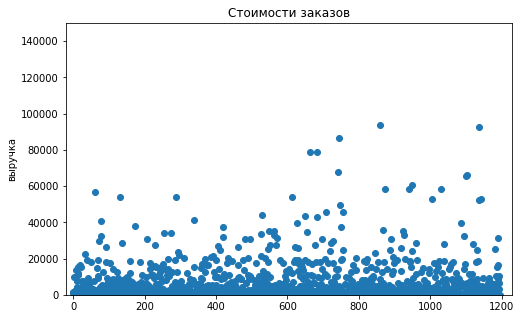

In [68]:
# точечный график стоимостей заказов
plt.figure(figsize=(8, 5))
plt.scatter(x_values_2, orders['revenue']) 
plt.title('Стоимости заказов')
plt.ylabel('выручка')
plt.axis([-20, 1230, 0, 150000])
plt.show()

Ниже построим точечный график стоимостей заказов с разбивкой по группе теста.

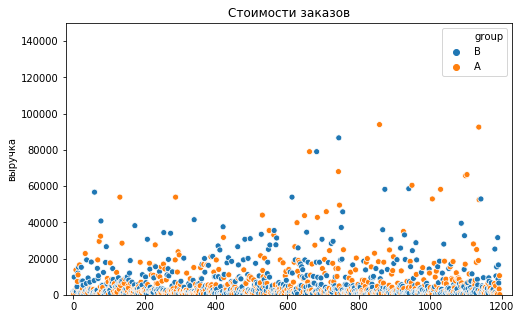

In [69]:
# точечный график стоимостей заказов с разбивкой по группам
plt.figure(figsize=(8, 5))
sns.scatterplot(pd.Series(range(0,len(orders['revenue']))), y='revenue', hue='group', data=orders)
plt.title('Стоимости заказов')
plt.ylabel('выручка')
plt.axis([-20, 1230, 0, 150000])
plt.show()

Ниже расположим оба графика бок о бок.

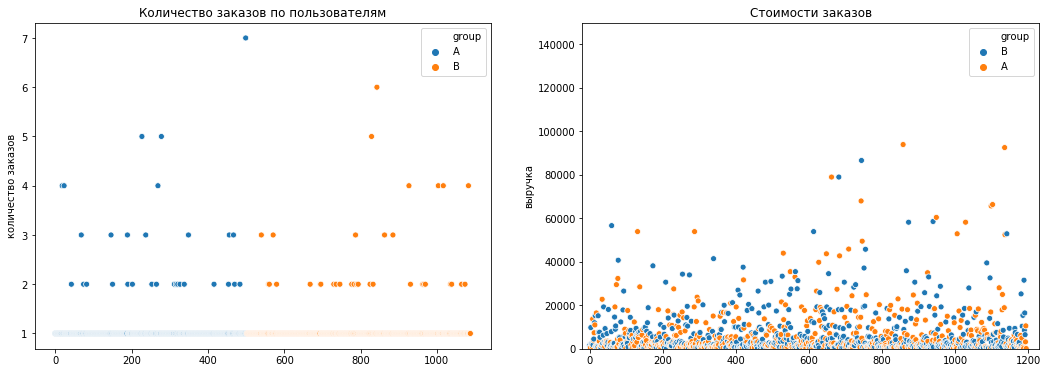

In [70]:
# график 1: количество заказов на пользователя
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(pd.Series(range(0,len(orders_by_users))), y='orders', hue='group', data=orders_by_users)
plt.title('Количество заказов по пользователям')
plt.ylabel('количество заказов')

# график 2: стоимости заказов
plt.subplot(1, 2, 2)
sns.scatterplot(pd.Series(range(0,len(orders['revenue']))), y='revenue', hue='group', data=orders)
plt.title('Стоимости заказов')
plt.ylabel('выручка')
plt.axis([-20, 1230, 0, 150000])

plt.show()

Есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов между 25 000 и 40 000. 

Посчитаем 95-й и 99-й перцентили стоимости заказов, чтобы выбрать границу для определения аномальных заказов.

In [71]:
# считаем 95-й и 99-й перцентили
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28 000 и не более 1% дороже 58 233. В качестве границы для определения аномальных заказов можно взять сумму в 30 000.

<a href="#contents">к оглавлению</a>

 Создадим одну общую объединенную таблицу из таблицы с заказами и таблицы с посетителями.

In [72]:
# таблица с пользователями группы А
visitors_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]

In [73]:
visitors_A.columns = ['date', 'visitors_A']

In [74]:
visitors_A.head()

,date,visitors_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [75]:
# таблица с кумулятивным числом пользователей группы А
visitors_A_cumulative = visitors_A.apply(
    lambda x: visitors_A[visitors_A['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_A': 'sum'}
    ),
    axis=1,
)

In [76]:
visitors_A_cumulative.columns = ['date', 'visitors_A_cumulative']

In [77]:
visitors_A_cumulative.head()

,date,visitors_A_cumulative
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [78]:
# таблица с пользователями группы B
visitors_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [79]:
visitors_B.columns = ['date', 'visitors_B']

In [80]:
visitors_B.head()

,date,visitors_B
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [81]:
# таблица с кумулятивным числом пользователей группы B
visitors_B_cumulative = visitors_B.apply(
    lambda x: visitors_B[visitors_B['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_B': 'sum'}
    ),
    axis=1,
)

In [82]:
visitors_B_cumulative.columns = ['date', 'visitors_B_cumulative']

In [83]:
visitors_B_cumulative.head()

,date,visitors_B_cumulative
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [84]:
# таблица с заказами группы А
orders_A = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)

In [85]:
orders_A.columns = ['date', 'orders_A', 'revenue_A']

In [86]:
orders_A.head()

,date,orders_A,revenue_A
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [87]:
# таблица с кумулятивными заказами группы А
orders_A_cumulative = orders_A.apply(
    lambda x: orders_A[orders_A['date'] <= x['date']].agg(
        {'date': 'max', 'orders_A': 'sum', 'revenue_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [88]:
orders_A_cumulative.columns = [
    'date',
    'orders_A_cumulative',
    'revenue_A_cumulative',
]

In [89]:
orders_A_cumulative.head()

,date,orders_A_cumulative,revenue_A_cumulative
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [90]:
# таблица с заказами группы B
orders_B = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)

In [91]:
orders_B.columns = ['date', 'orders_B', 'revenue_B']

In [92]:
orders_B.head()

,date,orders_B,revenue_B
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [93]:
# таблица с кумулятивными заказами группы B
orders_B_cumulative = orders_B.apply(
    lambda x: orders_B[orders_B['date'] <= x['date']].agg(
        {'date': 'max', 'orders_B': 'sum', 'revenue_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [94]:
orders_B_cumulative.columns = [
    'date',
    'orders_B_cumulative',
    'revenue_B_cumulative',
]

In [95]:
orders_B_cumulative.head()

,date,orders_B_cumulative,revenue_B_cumulative
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [96]:
# объединяем все таблицы в одну
data = (
    orders_A.merge(
        orders_B, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A, left_on='date', right_on='date', how='left')
    .merge(visitors_B, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cumulative, left_on='date', right_on='date', how='left')
)

In [97]:
data.head()

,date,orders_A,revenue_A,orders_B,revenue_B,orders_A_cumulative,revenue_A_cumulative,orders_B_cumulative,revenue_B_cumulative,visitors_A,visitors_B,visitors_A_cumulative,visitors_B_cumulative
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Мы получили одну объединенную таблицу data, где:
- date — дата;
- orders_A — количество заказов в выбранную дату в группе A;
- revenue_A — суммарная выручка в выбранную дату в группе A;
- orders_B — количество заказов в выбранную дату в группе B;
- revenue_B — суммарная выручка в выбранную дату в группе B;
- orders_A_cumulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_A_cumulative — суммарная выручка до выбранной даты включительно в группе A;
- orders_B_cumulative — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_B_cumulative — суммарная выручка до выбранной даты включительно в группе B;
- visitors_A — количество пользователей в выбранную дату в группе A;
- visitors_B — количество пользователей в выбранную дату в группе B;
- visitors_A_cumulative — количество пользователей до выбранной даты включительно в группе A;
- visitors_B_cumulative — количество пользователей до выбранной даты включительно в группе B.

In [98]:
# создадим таблицу для группы А с пользователями, которые заказывали хотя бы 1 раз, и укажем число совершённых заказов
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)\
                .agg({'transaction_id': 'nunique'})

In [99]:
orders_by_users_A.columns = ['visitor_id', 'orders']

In [100]:
orders_by_users_A.head()

,visitor_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [101]:
# создадим таблицу для группы B с пользователями, которые заказывали хотя бы 1 раз, и укажем число совершённых заказов
orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)\
                .agg({'transaction_id': 'nunique'})

In [102]:
orders_by_users_B.columns = ['visitor_id', 'orders']

In [103]:
orders_by_users_B.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [104]:
# создадим серию из заказов на каждого пользователя для выборки А, 
# соединив вертикально с серией из нулей для пользователей, не совершивших ни одного заказа
sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [105]:
sample_A.head(6)

0    1
1    1
2    1
3    1
4    1
5    1
Name: orders, dtype: int64

In [106]:
# создадим серию из заказов на каждого пользователя для выборки B, 
# соединив вертикально с серией из нулей для пользователей, не совершивших ни одного заказа
sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [107]:
sample_B.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

<a href="#contents">к оглавлению</a>

Ниже сформулированы нулевая и альтернативная гипотезы по конверсии.

Чтобы рассчитать статистическую значимость различий в показателях между сегментами используем непараметрический критерий Манна-Уитни. За уровень статистической значимости возьмем $\alpha=0.05$. Мы будем использовать двусторонний тест, так как в данном случае мы проверяем равенство или неравенство показателей двух выборок. Запишем нулевую и альтернативную гипотезы:

$\textbf{H_0}$: Различия между конверсиями в группе А и в группе Б не являются статистически значимыми.

$\textbf{H_1}$: Различия между конверсиями в группе А и в группе Б  статистически значимы.

Альтернативная гипотеза является нашей рабочей гипотезой и ее мы проверяем. 

In [108]:
# посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
print("{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1], True, 'two-sided'))

0.008


Посчитаем также относительное изменение конверсии группы B к группе A.

In [109]:
# относительное изменение конверсии группы B к группе A по «сырым» данным
print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.138


По «сырым» данным конверсии групп A и B различаются. Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Ниже сформулированы нулевая и альтернативная гипотезы по средним чекам.

Чтобы рассчитать статистическую значимость различий в среднем чеке  между сегментами также используем непараметрический критерий Манна-Уитни. За уровень статистической значимости возьмем $\alpha=0.05$. Мы будем использовать двусторонний тест, так как в данном случае мы проверяем равенство или неравенство показателей двух выборок. Запишем нулевую и альтернативную гипотезы:

$\textbf{H_0}$: Различия между средними чеками в группе А и в группе Б не являются статистически значимыми.

$\textbf{H_1}$: Различия между средними чеками в группе А и в группе Б статистически значимы.

Альтернативная гипотеза является нашей рабочей гипотезой и ее мы проверяем. 

In [110]:
# посчитаем статистическую значимость различий в среднем чеке по «сырым» данным
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                          orders[orders['group']=='B']['revenue'])[1], True, 'two-sided'))

0.365


Найдем также относительное изменение в среднем чеке группы В по отношению к группе А.

In [111]:
# относительные различие в среднем чеке между группами по «сырым» данным
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


P-value 0.365 больше 0.05, значит, нам не удалось отвергнуть нулевую гипотезу о равенстве средих чеков. Что касается относительного изменения, средний чек группы B больше среднего чека группы A.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «очищенным» данным. Примем за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 30 000. Так мы уберём около 2% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

In [112]:
# срез пользователей с числом заказов больше 2
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)

In [113]:
# срез пользователей, совершивших заказы дороже 30 000 
users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

In [114]:
# объединим два среза в один список с аномальными пользователями
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [115]:
abnormal_users.head(5)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

In [116]:
abnormal_users.shape

(68,)

Имеется 68 аномальных пользователей. Теперь подготовим выборки количества заказов и средних чеков по пользователям по группам теста, отсеяв аномальных пользователей.

In [117]:
# создадим серию из заказов на каждого пользователя для выборки А, отбросив аномальных пользователей
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [118]:
# создадим серию из заказов на каждого пользователя для выборки А, отбросив аномальных пользователей
sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «очищенным» данным. Нулевая и альтернативная гипотезы остаются прежними.

In [119]:
# посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным
print('{0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1], True, 'two-sided'))

0.007


In [120]:
# относительное изменение конверсии группы B к группе A по «очищенным» данным
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

0.172


По «очищенным» данным результаты почти не изменились. По-прежнему делаем вывод, что конверсии групп A и B различаются. Относительный выигрыш группы B увеличился немного и равен 17.2%.

Теперь посчитаем статистическую значимость различий в среднем чеке по «очищенным» данным.

In [121]:
# статистическая значимость различий в среднем чеке по «очищенным» данным
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1], True, 'two-sided'
    )
)

0.360


In [122]:
# относительные различие в среднем чеке между группами по «очищенным» данным
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

-0.023


На этот раз мы видим изменения после очищения данных. Статистика по конверсии не изменилась, мы по-прежнему не можем отвергнуть нулевую гипотезу о равенстве средних чеков. Что касается относительного изменения среднего чека группы B к среднему чеку группы A, то оно стало отрицательным -2.3%. Средний чек группы B стал ниже чека группы A. Значит, все-таки аномальные суммы заказов оказывали большое влияние на средний чек.

### Вывод
По результатам анализа A/B-теста выяснили, что:
- график кумулятивной выручки показывает, что группа B лидирует почти с самого начала;
- график кумулятивного значения среднего чека по группам показывает, что группа B закрепилась в позиции лидера начиная с середины теста;
- график относительного изменения кумулятивного среднего чека группы B к группе A показывает, что большую часть теста лидировала группа B;
- график кумулятивной конверсии показывает, что группа B зафиксировалась около одного значения, больше значения группы A;
- график относительного изменения кумулятивной конверсии группы B к группе A показывает, что почти с самого начала группа B лидирует по конверсии, фиксируясь около прироста в 15% относительно группы A.

По результатам тестов статистической значимости показателей по группам теста выяснили, что:
- есть статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий;
- относительный выигрыш группы B равен 13.8%, после фильтрации он еще увеличился;
- нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- относительное изменение средего чека группы B к группе A положительное по «сырым» данным, а после фильтрации стало отрицательным.

<a href="#contents">к оглавлению</a>

## Выводы и рекомендации

В данном проекте мы приоритизировали гипотезы для увеличения выручки интернет-магазина, затем анализировали результаты A/B-теста. Мы работали с тремя источниками информации:

- данные по гипотезамс гипотезами;
- данные о покупках в интернет-магазине; 
- визиты на веб-сайт интернет магазина;

В данных нет пропусков. Были заменены лишь типы данных в столбцах с датой и временем.

По результатам приоритизации гипотез, мы выяснили, что:

- при применении фреймворка ICE лидируют гипотезы под индексом 8, 0 и 7;
- при применении фреймворка RICE лидируют гипотезы под индексом 7, 2, 0 и 6;
- при применении фреймворка ICE, в лидеры выбилась гипотеза под индексом  7, так как ее показатель reach равен 10;
- гипотеза под индексом 0 находится в числе лидеров по результатам применения обоих фреймворков, за счет высокого показателя impact в 10 баллов.

Лидирующая гипотеза под индексом 7 гласит: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Для статистических тестов мы использовали критерий Манна-Уитни и использовали уровень значимости 0.05. Проанализировав графики и перцентили, мы приняли решение использовать порог количества заказов в 2 заказа на посетителя, и порог суммы одного заказа в 30 000.

По результатам анализа A/B-теста выяснили, что:

- график кумулятивной выручки показывает, что группа B лидирует почти с самого начала;
- график кумулятивного значения среднего чека по группам показывает, что группа B закрепилась в позиции лидера начиная с середины теста;
- график относительного изменения кумулятивного среднего чека группы B к группе A показывает, что большую часть теста лидировала группа B;
- график кумулятивной конверсии показывает, что группа B зафиксировалась около одного значения, больше значения группы A;
- график относительного изменения кумулятивной конверсии группы B к группе A показывает, что почти с самого начала группа B лидирует по конверсии, фиксируясь около прироста в 15% относительно группы A;

- есть статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий;
- относительный выигрыш группы B по конверсии равен 13.8%, после фильтрации он еще увеличился до 17.2%;
- нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- относительное изменение средего чека группы B к группе A положительное по «сырым» данным, а после фильтрации стало отрицательным.

<div class="alert alert-info">
    <strong>Рекомендация:</strong> Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы B. Целью теста является увеличение выручки, а выручка напрямую зависит от конверсии. Группа B показала лучшие результаты по кумулятивной конверсии и кумулятивной выручке. Относительный выигрыш группы B по конверсии составляет 17.2%, что существенно. К тому же, статистический тест выявил значительное различие в конверсии между группами.    
</div>

<a href="#contents">к оглавлению</a>